<a href="https://www.kaggle.com/code/royindrapratama/mit-bih-cnn-lstm?scriptVersionId=246793368" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import resample_poly
from typing import Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import pywt
from scipy.signal import remez, filtfilt, freqz, savgol_filter
from scipy.datasets import electrocardiogram
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

# Define Functions

In [2]:
def add_powerline_noise(signal, freq=50, fs=360, amplitude=0.05):
    t = np.arange(len(signal)) / fs
    noise = amplitude * np.sin(2 * np.pi * freq * t)
    return signal + noise

def add_baseline_wander(signal, freq=0.3, fs=360, amplitude=0.2):
    t = np.arange(len(signal)) / fs
    drift = amplitude * np.sin(2 * np.pi * freq * t)
    return signal + drift

def add_muscle_bursts(signal, burst_prob=0.01, burst_amplitude=0.2):
    mask = np.random.rand(len(signal)) < burst_prob
    bursts = np.random.normal(0, burst_amplitude, size=len(signal))
    emg_bursts = np.where(mask, bursts, 0)
    return signal + emg_bursts

def add_motion_artifact(signal, num_artifacts=3, max_shift=0.3):
    signal = signal.copy()
    for _ in range(num_artifacts):
        pos = np.random.randint(0, len(signal))
        length = np.random.randint(10, 50)
        shift = np.random.uniform(-max_shift, max_shift)
        signal[pos:pos+length] = signal[pos:pos+length] + shift
    return signal

def add_electrode_noise(signal, num_flat=2, flat_length=30):
    signal = signal.copy()
    for _ in range(num_flat):
        start = np.random.randint(0, len(signal) - flat_length)
        signal[start:start+flat_length] = signal[start]  # Flatline
    return signal

def add_instrumentation_noise(signal, std=0.01):
    noise = np.random.normal(0, std, len(signal))
    return signal + noise

def add_combined_noise(signal, fs=360):
    signal = add_powerline_noise(signal, freq=50, fs=fs, amplitude=0.2)
    signal = add_baseline_wander(signal, freq=0.3, fs=fs, amplitude=0.1)
    signal = add_muscle_bursts(signal, burst_prob=0.01, burst_amplitude=0.1)
    signal = add_motion_artifact(signal, num_artifacts=2, max_shift=2)
    signal = add_electrode_noise(signal, num_flat=1, flat_length=25)
    signal = add_instrumentation_noise(signal, std=0.005)
    return signal

In [3]:
class Callback:
    def on_train_begin(self, logs: Dict[str, Any] = None):
        pass

    def on_epoch_begin(self, epoch: int, logs: Dict[str, Any] = None):
        pass

    def on_batch_end(self, batch: int, logs: Dict[str, Any] = None):
        pass

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None):
        pass

    def on_train_end(self, logs: Dict[str, Any] = None):
        pass

class CallbackHandler: #Manages and executes callbacks
    def __init__(self, callbacks: list): #Stores list of callback objects
        self.callbacks = callbacks

    def _trigger(self, method_name: str, **kwargs): #Executes named method on all callbacks that implement it
        for callback in self.callbacks:
            if hasattr(callback, method_name): #checks if the callback implements that method.
                method = getattr(callback, method_name) #If it does, it retrieves the method
                method(**kwargs)# Pass all kwargs directly
        
class ModelCheckpoint(Callback):
    def __init__(self, filepath_template: str, fold: int, monitor='val_loss', save_best_only=True):
        self.filepath = filepath_template.format(fold=fold)  # Include fold in path
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best_value = float('inf')
        self.fold = fold  # Track fold internally

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs[self.monitor]
        model = logs.get('model')
        
        if current_value < self.best_value:
            self.best_value = current_value
            torch.save(model.state_dict(), self.filepath)
            print(f"\nSaved model for Fold {self.fold} at epoch {epoch}")
            
class EarlyStopping(Callback):
    """
    Stop training when validation loss reaches a specified threshold.
    Optionally includes patience-based stopping for robustness.
    """
    def __init__(self, 
                 threshold: float,
                 monitor: str = 'val_loss',
                 patience: int = 0,
                 save_best: bool = False,
                 filepath: str = 'best_model.pth'):
        self.threshold = threshold
        self.monitor = monitor
        self.patience = patience
        self.save_best = save_best
        self.filepath = filepath
        self.best_value = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None, model: torch.nn.Module = None):
        current_value = logs[self.monitor]
        model = logs.get('model')

        if model is None:
            raise ValueError("Model not passed to EarlyStopping callback!")
        
        # Save best model 
        if self.save_best and current_value < self.best_value:
            self.best_value = current_value
            torch.save(model.state_dict(), self.filepath)
            print(f"Saved best model with {self.monitor}: {current_value:.4f}")

        # Threshold-based stopping
        if current_value <= self.threshold:
            print(f"\n{self.monitor} reached {current_value:.4f} <= {self.threshold}. Stopping training.")
            logs['stop_training'] = True
            
        # Patience-based stopping 
        elif current_value > self.best_value:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nNo improvement for {self.patience} epochs. Early stopping.")
                logs['stop_training'] = True

In [4]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_channels, seq_length, n_classes):
        super(CNNBiLSTM, self).__init__()
        
        # Store parameters
        self.input_channels = input_channels
        self.seq_length = seq_length
        self.n_classes = n_classes
        
        # Convolutional layers 
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, padding=3)  
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2, stride=2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2, stride=2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2, stride=2)
        
        # Calculate LSTM 
        self.lstm_input_size = 256
        self.lstm_seq_length = seq_length // 8  
        
        # Bidirectional LSTM 
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=128,  
            num_layers=2,     
            bidirectional=True,
            batch_first=True,
            dropout=0.3       
        )
        
        # Attention mechanism 
        self.attention = nn.MultiheadAttention(
            embed_dim=256,  # 128*2 for bidirectional
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Fully connected layers 
        self.fc1 = nn.Linear(256, 128)  # 128*2 for bidirectional LSTM
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, n_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights for better training stability"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        # Input shape: (batch_size, seq_len, features) or (batch_size, features, seq_len)
        
        '''
        if x.dim() == 2:
            # If input is (batch, seq_len), add channel dimension
            x = x.unsqueeze(1)  # (batch, 1, seq_len)
        elif x.dim() == 3:
            # If input is (batch, seq_len, features), transpose to (batch, features, seq_len)
            if x.size(1) > x.size(2):
                x = x.permute(0, 2, 1)
        '''
        x = x.permute(0, 2, 1)
        # Convolutional 
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        # for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        
        # Bidirectional LSTM
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling 
        x = torch.mean(attn_out, dim=1)  # (batch, features)
        
        # Fully connected 
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [5]:
def test_model(model, test_loader, criterion, device='auto'):
    """
    Evaluate model performance on test dataset
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test dataset
        criterion: Loss function
        device: 'cuda' or 'cpu' (default: auto-detect)
    
    Returns:
        Dictionary containing test_loss and test_accuracy
    """
    # Device configuration
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
        
    model = model.to(device)
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_inputs = X_val_tensor.to(device)
        test_targets = torch.argmax(y_val_tensor, dim=1).to(device)

        test_inputs = test_inputs.permute(0, 2, 1)
        outputs = model(test_inputs)
        _, predictions = torch.max(outputs, 1)
        y_pred = predictions.cpu().numpy()
        y_true = test_targets.cpu().numpy()

        val_loss = criterion(outputs, test_targets).item()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # For AUC
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        try:
            auc = roc_auc_score(y_val_cat, probs, average='weighted', multi_class='ovr')
        except ValueError:
            auc = 0.0  # If ROC AUC can't be computed
    
    print(f"✅  Accuracy : {acc:.4f}")
    print(f"✅  Precision: {prec:.4f}")
    print(f"✅  Recall   : {rec:.4f}")
    print(f"✅  F1 Score : {f1:.4f}")
    print(f"✅  AUC      : {auc:.4f}")
    print(f"✅  AUROC    : {auc:.4f}")
    

    
    return {
        'auroc': auc,
        'auc': auc,
        'test_loss': val_loss,
        'test_accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }


In [6]:
def to_categorical_torch(y, num_classes=None):
    y = torch.tensor(y, dtype=torch.long)
    if num_classes is None:
        num_classes = torch.max(y).item() + 1
    return F.one_hot(y, num_classes=num_classes).float()

# Import Dataset

## Separate Records and Annotations

In [7]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
filenames = next(os.walk(path))[2] #would return the filenames in the path directory only

records = list() #list for storing .csv file in dataset
annotations = list() #list for storing .txt file in dataset 
filenames.sort()

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    else:
        annotations.append(path + filename + file_extension)

## Looping Over Records

In [8]:
X = list()
y = list()

classes = ['N', 'L', 'R', 'A', 'V', '/']
count_classes = [0]*len(classes)
window_size = 160

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_18/36439448.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if record_index is 1:


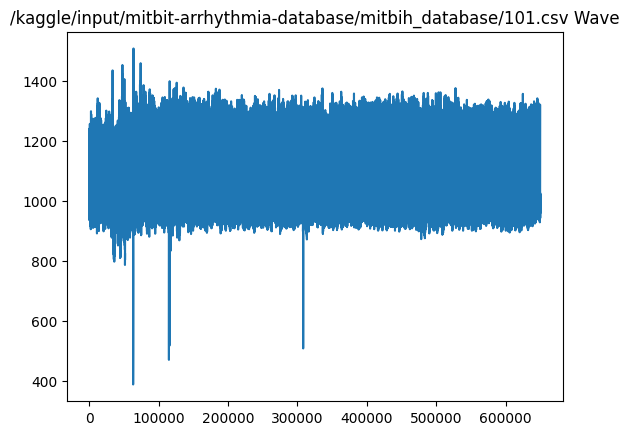

In [9]:
for record_index in range(0,len(records)):
    # ===== Reading and Storing Signals Data =====
    signals = []

    with open(records[record_index], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # ===== Plot the Signals for Data with Index 1 =====
    if record_index is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals)
        plt.show()

    # ===== Read anotations: R position and Arrhythmia class =====
    with open(annotations[record_index], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID

            # ===== Extracting Valid Beats =====
            
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                #if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
                #else:
                count_classes[arrhythmia_index] += 1
                if(window_size < pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size+1:pos+window_size]
                    X.append(beat)
                    y.append(arrhythmia_index)

0
0    75014
1     8071
2     7255
4     7129
5     7023
3     2546
Name: count, dtype: int64


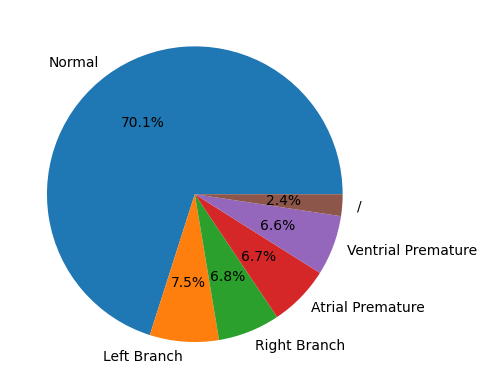

In [10]:
X_train_df = pd.DataFrame(X)
y_train_df = pd.DataFrame(y)

per_class = y_train_df.value_counts()
print(per_class)


plt.pie(per_class, labels=['Normal', 'Left Branch', 'Right Branch', 'Atrial Premature', 'Ventrial Premature', '/'], autopct='%1.1f%%')
plt.show()

# Split

In [11]:
# Convert X to numpy array
X = np.array(X, dtype=np.float32)  # Shape: (num_samples, 320)
y = np.array(y)

print(f"X counts : {len(X)}")
print(f"y counts : {len(y)}")

print(f"X shape : {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X counts : {X_train.shape}")
print(f"y counts : {y_train.shape}")
print(f"X counts : {X_test.shape}")
print(f"y counts : {y_test.shape}")

np.save('X.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y.npy', y_train)
np.save('test.npy', y_test)

X counts : 107038
y counts : 107038
X shape : (107038, 319)
X counts : (85630, 319)
y counts : (85630,)
X counts : (21408, 319)
y counts : (21408,)


# Add Noise

In [12]:
X_2 = X_train.copy()
noisy_signal = []
for a in X_2:
    noisy_signal.append(add_combined_noise(a))

In [13]:
X_augmented = np.concatenate((X_train, noisy_signal), axis=0)
y_augmented = np.concatenate((y_train, y_train), axis=0)  

np.save('X_augmented.npy', X_augmented)
np.save('y_augmented.npy', y_augmented)

# K Fold

In [14]:
y = np.load('/kaggle/working/y_augmented.npy')
X = np.load('/kaggle/working/X_augmented.npy')
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')

In [15]:
n_classes = len(np.unique(y))
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

#X, y = create_windows(X, y, window_size=187)
print(len(X), len(y))
#X = X[:len(y)]

fold_accuracies = []

171260 171260


# Modeling

In [16]:
train_means = []
train_stds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n🔁 Fold {fold+1}/{k_folds}")
    # Get fold data (X_train, X_test, y_train_cat, y_test_cat)
    # Convert to PyTorch tensors
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    '''
    train_mean = X_train.mean()
    train_means.append(train_mean)
    train_std = X_train.std()
    train_stds.append(train_std)
    
    X_train = (X_train - train_mean) / train_std
    X_val = (X_val - train_mean) / train_std
    '''
    y_train_cat = to_categorical_torch(y_train, num_classes=n_classes)
    y_val_cat = to_categorical_torch(y_val, num_classes=n_classes)
    
    X_train = [resample_poly(signal, up=100, down=187) for signal in X_train]
    X_train = np.array(X_train)
    X_val = [resample_poly(signal, up=100, down=187) for signal in X_val]
    X_val = np.array(X_val)
    print(X_train.shape)
    print(X_val.shape)
    
    train_mean = X_train.mean()
    train_means.append(train_mean)
    train_std = X_train.std()
    train_stds.append(train_std)
    
    X_train = X_train[:, np.newaxis, :]
    X_val = X_val[:, np.newaxis, :]
    
    X_train = (X_train - train_mean) / train_std
    X_val = (X_val - train_mean) / train_std
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    #y_train_tensor = torch.tensor(y_train_cat, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    #y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
    y_train_tensor = y_train_cat.clone().detach()
    y_val_tensor = y_val_cat.clone().detach()
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    callbacks = [ModelCheckpoint(
        filepath_template='best_model{fold}.pth',
        fold=fold,
        monitor='val_loss',
        save_best_only=True
    )]
    
    callback_handler = CallbackHandler(callbacks or [])
    logs = {}
    callback_handler._trigger('on_train_begin', logs=logs)
    
    
    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNBiLSTM(
        input_channels=1,
        seq_length=X_train.shape[2],
        n_classes=n_classes
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  
    optimizer = optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    
    
    for epoch in range(10):
        torch.cuda.empty_cache()
        print(f"\n\nEpoch: {epoch + 1}")
        callback_handler._trigger('on_epoch_begin', epoch=epoch, logs=logs)
        
        # Training loop
        model.train()
        running_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            #print(batch_x.dim)
            batch_x = batch_x.permute(0, 2, 1)
            #print(batch_x.dim)
            optimizer.zero_grad()
            outputs = model(batch_x)
            targets = torch.argmax(batch_y, dim=1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"📚 Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_inputs = X_val_tensor.to(device)
            test_targets = torch.argmax(y_val_tensor, dim=1).to(device)
            
            test_inputs = test_inputs.permute(0, 2, 1)
            outputs = model(test_inputs)
            _, predictions = torch.max(outputs, 1)
            y_pred = predictions.cpu().numpy()
            y_true = test_targets.cpu().numpy()

            val_loss = criterion(outputs, test_targets).item()

            acc = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            # For AUC, we use predicted probabilities
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            try:
                auc = roc_auc_score(y_val_cat, probs, average='weighted', multi_class='ovr')
            except ValueError:
                auc = 0.0  # If ROC AUC can't be computed

            logs = {'val_loss': val_loss, 'model': model}
            callback_handler._trigger('on_epoch_end', epoch=epoch, logs=logs)
            if logs.get('stop_training'):
                break
                
    callback_handler._trigger('on_train_end', logs=logs)

    fold_accuracies.append(acc)
    
    print(f"✅ Fold {fold+1} Accuracy : {acc:.4f}")
    print(f"✅ Fold {fold+1} Precision: {prec:.4f}")
    print(f"✅ Fold {fold+1} Recall   : {rec:.4f}")
    print(f"✅ Fold {fold+1} F1 Score : {f1:.4f}")
    print(f"✅ Fold {fold+1} AUC      : {auc:.4f}")
    print(f"✅ Fold {fold+1} AUROC    : {auc:.4f}")

# Final average
print(f"\n📊 Final K-Fold Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


🔁 Fold 1/5
(137008, 171)
(34252, 171)


Epoch: 1
📚 Epoch 1 Loss: 0.5500

Saved model for Fold 0 at epoch 0


Epoch: 2
📚 Epoch 2 Loss: 0.1692

Saved model for Fold 0 at epoch 1


Epoch: 3
📚 Epoch 3 Loss: 0.1214


Epoch: 4
📚 Epoch 4 Loss: 0.1002

Saved model for Fold 0 at epoch 3


Epoch: 5
📚 Epoch 5 Loss: 0.0921


Epoch: 6
📚 Epoch 6 Loss: 0.0875

Saved model for Fold 0 at epoch 5


Epoch: 7
📚 Epoch 7 Loss: 0.0713


Epoch: 8
📚 Epoch 8 Loss: 0.0663


Epoch: 9
📚 Epoch 9 Loss: 0.0655

Saved model for Fold 0 at epoch 8


Epoch: 10
📚 Epoch 10 Loss: 0.0640

Saved model for Fold 0 at epoch 9
✅ Fold 1 Accuracy : 0.9820
✅ Fold 1 Precision: 0.9836
✅ Fold 1 Recall   : 0.9820
✅ Fold 1 F1 Score : 0.9824
✅ Fold 1 AUC      : 0.9995
✅ Fold 1 AUROC    : 0.9995

🔁 Fold 2/5
(137008, 171)
(34252, 171)


Epoch: 1
📚 Epoch 1 Loss: 0.5692

Saved model for Fold 1 at epoch 0


Epoch: 2
📚 Epoch 2 Loss: 0.1778

Saved model for Fold 1 at epoch 1


Epoch: 3
📚 Epoch 3 Loss: 0.1238

Saved model for Fold 1 at epoch 2



In [17]:
train_means = np.array(train_means)
train_stds = np.array(train_stds)
np.save('train_means.npy', train_means)
np.save('train_stds.npy', train_stds)

# Test

In [18]:
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')

y_test_cat = to_categorical_torch(y_test, num_classes=6)
X_test = X_test[:, np.newaxis, :]

X_test = [resample_poly(signal, up=100, down=187) for signal in X_test]
X_test = np.array(X_test)

X_test = (X_test - train_means[0]) / train_stds[0]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
y_test_tensor = y_test_cat.clone().detach()


model = CNNBiLSTM(
        input_channels=1,
        seq_length=171,
        n_classes=6
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)

model_path = '/kaggle/working/best_model0.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_test_tensor = X_test_tensor.to(device)
X_test_tensor = X_test_tensor.permute(0, 2, 1)

results = test_model(model, X_test_tensor, torch.nn.CrossEntropyLoss())

/tmp/ipykernel_18/33562825.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅  Accuracy : 0.9835
✅  Precision: 0.9849
✅  Recall   : 0.9835
✅  F1 Score : 0.9838
✅  AUC      : 0.9998
✅  AUROC    : 0.9998


In [19]:
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')


y_test_cat = to_categorical_torch(y_test, num_classes=6)
X_test = X_test[:, np.newaxis, :]

X_test = [resample_poly(signal, up=100, down=187) for signal in X_test]
X_test = np.array(X_test)

X_test = (X_test - train_means[1]) / train_stds[1]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
y_test_tensor = y_test_cat.clone().detach()

model = CNNBiLSTM(
        input_channels=1,
        seq_length=171,
        n_classes=6
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)

model_path = '/kaggle/working/best_model1.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

results = test_model(model, X_test_tensor, torch.nn.CrossEntropyLoss())

/tmp/ipykernel_18/1301329103.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅  Accuracy : 0.9697
✅  Precision: 0.9790
✅  Recall   : 0.9697
✅  F1 Score : 0.9724
✅  AUC      : 0.9997
✅  AUROC    : 0.9997


In [20]:
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')


y_test_cat = to_categorical_torch(y_test, num_classes=6)
X_test = X_test[:, np.newaxis, :]

X_test = [resample_poly(signal, up=100, down=187) for signal in X_test]
X_test = np.array(X_test)

X_test = (X_test - train_means[2]) / train_stds[2]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
y_test_tensor = y_test_cat.clone().detach()

model = CNNBiLSTM(
        input_channels=1,
        seq_length=171,
        n_classes=6
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)

model_path = '/kaggle/working/best_model2.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

results = test_model(model, X_test_tensor, torch.nn.CrossEntropyLoss())

/tmp/ipykernel_18/1225664697.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅  Accuracy : 0.9796
✅  Precision: 0.9835
✅  Recall   : 0.9796
✅  F1 Score : 0.9807
✅  AUC      : 0.9996
✅  AUROC    : 0.9996


In [21]:
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')


y_test_cat = to_categorical_torch(y_test, num_classes=6)
X_test = X_test[:, np.newaxis, :]

X_test = [resample_poly(signal, up=100, down=187) for signal in X_test]
X_test = np.array(X_test)

X_test = (X_test - train_means[3]) / train_stds[3]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
y_test_tensor = y_test_cat.clone().detach()

model = CNNBiLSTM(
        input_channels=1,
        seq_length=171,
        n_classes=6
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)

model_path = '/kaggle/working/best_model3.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

results = test_model(model, X_test_tensor, torch.nn.CrossEntropyLoss())

/tmp/ipykernel_18/1349326453.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅  Accuracy : 0.9808
✅  Precision: 0.9852
✅  Recall   : 0.9808
✅  F1 Score : 0.9820
✅  AUC      : 0.9998
✅  AUROC    : 0.9998


In [22]:
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/test.npy')


y_test_cat = to_categorical_torch(y_test, num_classes=6)
X_test = X_test[:, np.newaxis, :]

X_test = [resample_poly(signal, up=100, down=187) for signal in X_test]
X_test = np.array(X_test)

X_test = (X_test - train_means[3]) / train_stds[3]

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_cat, dtype=torch.float32)
y_test_tensor = y_test_cat.clone().detach()

model = CNNBiLSTM(
        input_channels=1,
        seq_length=171,
        n_classes=6
        #input_channels=319,  # Your feature dimension
        #seq_length=187,      # Your sequence length
        #n_classes=5          # Number of classes
    ).to(device)

model_path = '/kaggle/working/best_model4.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

results = test_model(model, X_test_tensor, torch.nn.CrossEntropyLoss())

/tmp/ipykernel_18/1744793072.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅  Accuracy : 0.9810
✅  Precision: 0.9839
✅  Recall   : 0.9810
✅  F1 Score : 0.9818
✅  AUC      : 0.9996
✅  AUROC    : 0.9996
